Baseline models performance (non-parametric, PNNs, AffinePNN) on both `Hepmass` and `Dataset`.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

from typing import List, Tuple, Dict, Union

%matplotlib inline
sns.set()

In [2]:
from script import free_mem, set_random_seed
from script import utils 

from script.datasets import Hepmass, Dataset
from script.models import NN, PNN, AffinePNN

from script.evaluation import hepmass as hepmass_eval
from script.evaluation import auc_with_error, auc_vs_no_mass, auc_vs_mass_no_features, \
                              metric_with_error

In [3]:
set_random_seed(42)

Random seed 42 set.


In [4]:
BATCH_SIZE = 100
VAL_SPLIT = 0.25
NUM_EPOCHS = 20

## Hepmass

In [5]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH)

loading...
fitting feature scaler..
fitting mass scaler..
dataset loaded.


In [6]:
free_mem()
x_train, y_train = data.get()

Non-parametric NN:

In [9]:
nn = NN(input_shapes=dict(m=(1,), x=(data.features.shape[-1],)), 
           units=[300, 150, 100, 50])

nn.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                       metrics.Precision(), metrics.Recall()])

checkpoint = ModelCheckpoint('weights/hepmass/baseline-nn/weights-{epoch:02d}-{val_auc:.3f}',
                             save_weights_only=True, monitor='val_auc',
                             mode='max', save_best_only=True)
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          8400        x[0][0]                          
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 150)          45150       dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          15100       dense_5[0][0]                    
________________________________________________________________________________________

In [10]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
              epochs=NUM_EPOCHS, callbacks=[checkpoint])

Epoch 1/20
52500/52500 [==============================] - 175s 3ms/step - loss: 0.3344 - binary_accuracy: 0.8171 - auc: 0.8931 - precision_1: 0.8564 - recall_1: 0.7622 - lr: 0.0010 - grad-norm: 0.5083 - weight-norm: 27.3606 - reg-losses: 0.0000e+00 - val_loss: 0.4001 - val_binary_accuracy: 0.8199 - val_auc: 0.8967 - val_precision_1: 0.8702 - val_recall_1: 0.7520
Epoch 2/20
52500/52500 [==============================] - 170s 3ms/step - loss: 0.3812 - binary_accuracy: 0.8197 - auc: 0.8966 - precision_1: 0.8595 - recall_1: 0.7644 - lr: 0.0010 - grad-norm: 0.3933 - weight-norm: 34.7094 - reg-losses: 0.0000e+00 - val_loss: 0.3985 - val_binary_accuracy: 0.8201 - val_auc: 0.8974 - val_precision_1: 0.8546 - val_recall_1: 0.7714
Epoch 3/20
52500/52500 [==============================] - 173s 3ms/step - loss: 0.3053 - binary_accuracy: 0.8208 - auc: 0.8981 - precision_1: 0.8612 - recall_1: 0.7651 - lr: 0.0010 - grad-norm: 0.3873 - weight-norm: 40.7445 - reg-losses: 0.0000e+00 - val_loss: 0.3961 - 

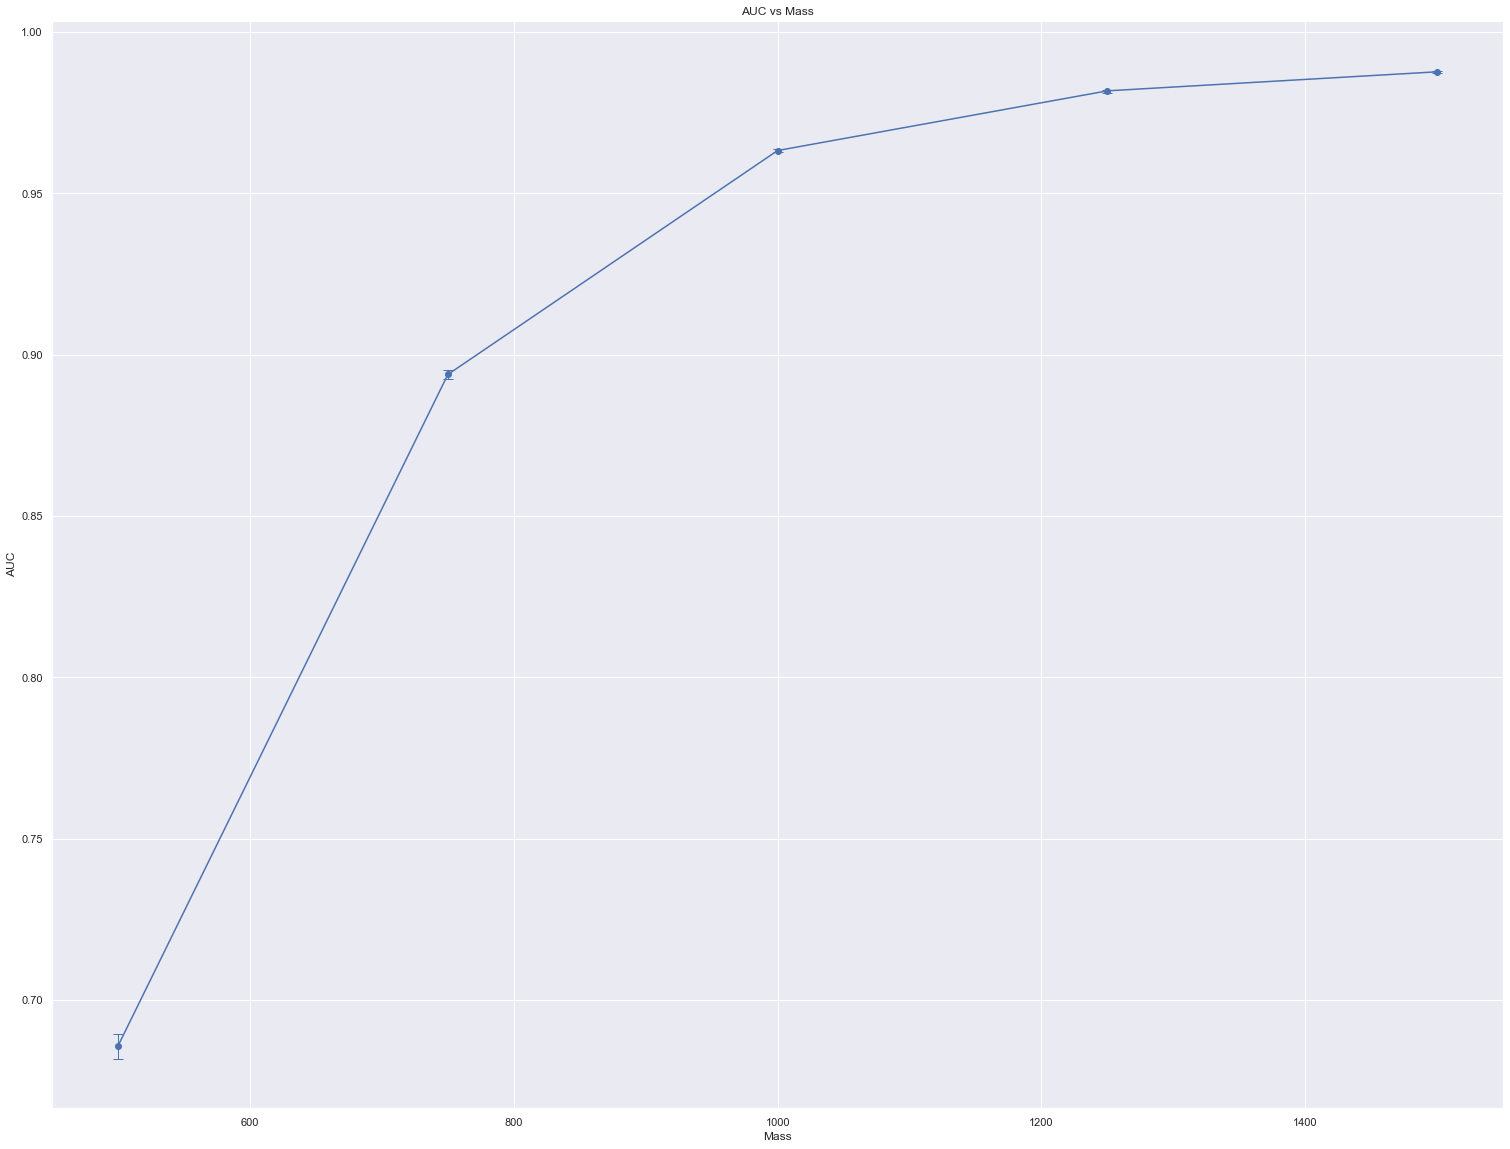

array([0.6859 , 0.89393, 0.96334, 0.9818 , 0.98773])

In [11]:
hepmass_eval.auc_with_error(nn, data, silent=True)

Parametric NN:

AffinePNN:

#### Robust
Clipped outliers

In [5]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH, robust=True)

free_mem()
x_train, y_train = data.get()

loading...
clipping outliers..
fitting feature scaler..
fitting mass scaler..
dataset loaded.


Non-parametric NN:

PNN:

In [8]:
pnn = PNN(input_shapes=dict(m=(1,), x=(data.features.shape[-1],)), 
          units=[300, 150, 100, 50])

pnn.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                     metrics.Precision(name='precision'), metrics.Recall(name='recal')])

checkpoint = ModelCheckpoint('weights/hepmass/baseline-pnn-robust/weights-{epoch:02d}-{val_auc:.3f}',
                             save_weights_only=True, monitor='val_auc',
                             mode='max', save_best_only=True)
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          8700        concatenate[0][0]     

In [9]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.79, AUC: 98.51

Epoch 1/20
41016/41016 [==============================] - 178s 4ms/step - loss: 0.1725 - binary_accuracy: 0.8956 - auc: 0.9701 - precision: 0.8868 - recal: 0.9072 - lr: 0.0010 - grad-norm: 1.4130 - weight-norm: 34.0749 - reg-losses: 0.0000e+00 - val_loss: 0.1767 - val_binary_accuracy: 0.9159 - val_auc: 0.9800 - val_precision: 0.9063 - val_recal: 0.9278
Epoch 2/20
41016/41016 [==============================] - 189s 5ms/step - loss: 0.1114 - binary_accuracy: 0.9102 - auc: 0.9774 - precision: 0.9037 - recal: 0.9183 - lr: 0.0010 - grad-norm: 1.3324 - weight-norm: 48.9700 - reg-losses: 0.0000e+00 - val_loss: 0.1819 - val_binary_accuracy: 0.9117 - val_auc: 0.9785 - val_precision: 0.9115 - val_recal: 0.9119
Epoch 3/20
41016/41016 [==============================] - 183s 4ms/step - loss: 0.1557 - binary_accuracy: 0.9154 - auc: 0.9798 - precision: 0.9086 - recal: 0.9237 - lr: 0.0010 - grad-norm: 1.1916 - weight-norm: 59.9208 - reg-losses: 0.0000e+00 - val_loss: 0.1709 - val_binary_accuracy: 0.91

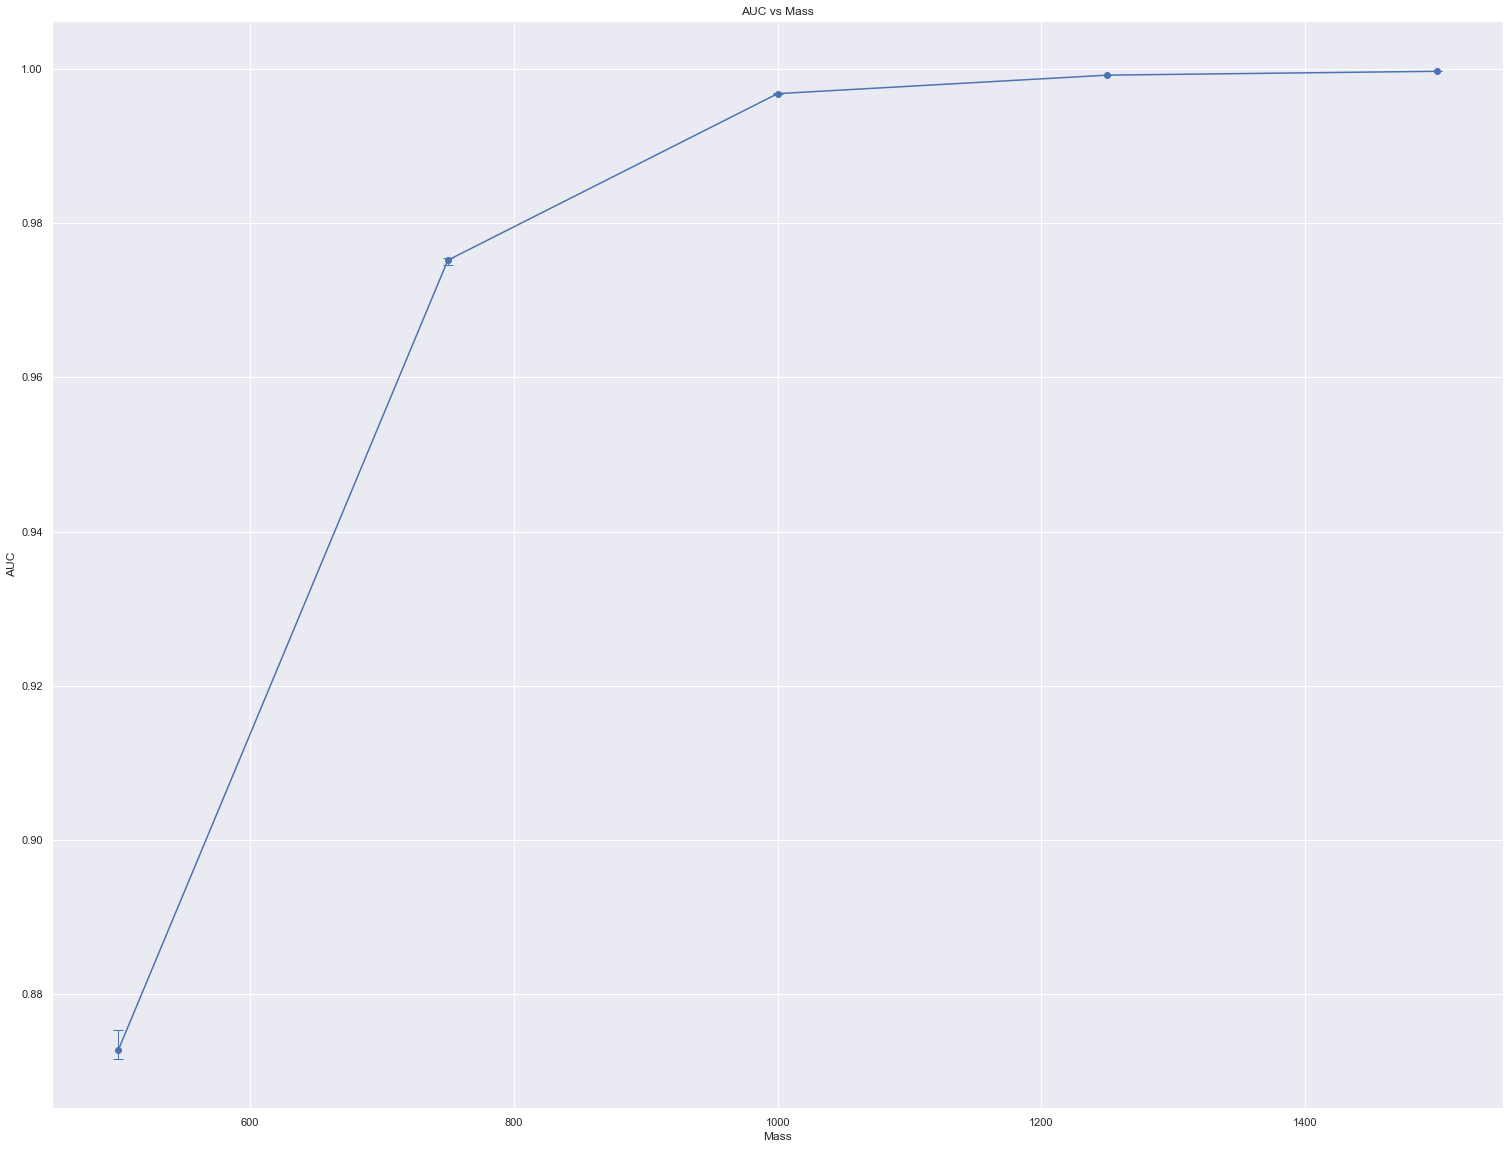

array([0.8727 , 0.97516, 0.99681, 0.9992 , 0.99972])

In [11]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

AffinePNN:

### Dataset

Non-parametric NN:

In [6]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

[signal] loading...
[background] loading...
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [7]:
free_mem()
x_train, y_train = data.get()

In [8]:
nn = NN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
        units=[300, 150, 100, 50])

nn.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                     metrics.Precision(name='precision'), metrics.Recall(name='recall')])

checkpoint = ModelCheckpoint('weights/tom/baseline-nn/weights-{epoch:02d}-{val_auc:.3f}',
                             save_weights_only=True, monitor='val_auc',
                             mode='max', save_best_only=True)
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          15100       dense_1[0][0]                    
________________________________________________________________________________________

In [11]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
              epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 83.60, AUC: 91.65

Epoch 1/10
27405/27405 [==============================] - 110s 4ms/step - loss: 0.4682 - binary_accuracy: 0.8346 - auc: 0.9147 - precision: 0.7886 - recall: 0.8474 - lr: 0.0010 - grad-norm: 0.7098 - weight-norm: 161.4235 - reg-losses: 0.0000e+00 - val_loss: 0.3609 - val_binary_accuracy: 0.8346 - val_auc: 0.9158 - val_precision: 0.7990 - val_recall: 0.8277
Epoch 2/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2991 - binary_accuracy: 0.8346 - auc: 0.9148 - precision: 0.7886 - recall: 0.8477 - lr: 0.0010 - grad-norm: 0.6937 - weight-norm: 169.8440 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accuracy: 0.8346 - val_auc: 0.9155 - val_precision: 0.7950 - val_recall: 0.8347
Epoch 3/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2882 - binary_accuracy: 0.8348 - auc: 0.9149 - precision: 0.7893 - recall: 0.8469 - lr: 0.0010 - grad-norm: 0.6806 - weight-norm: 177.6617 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accura

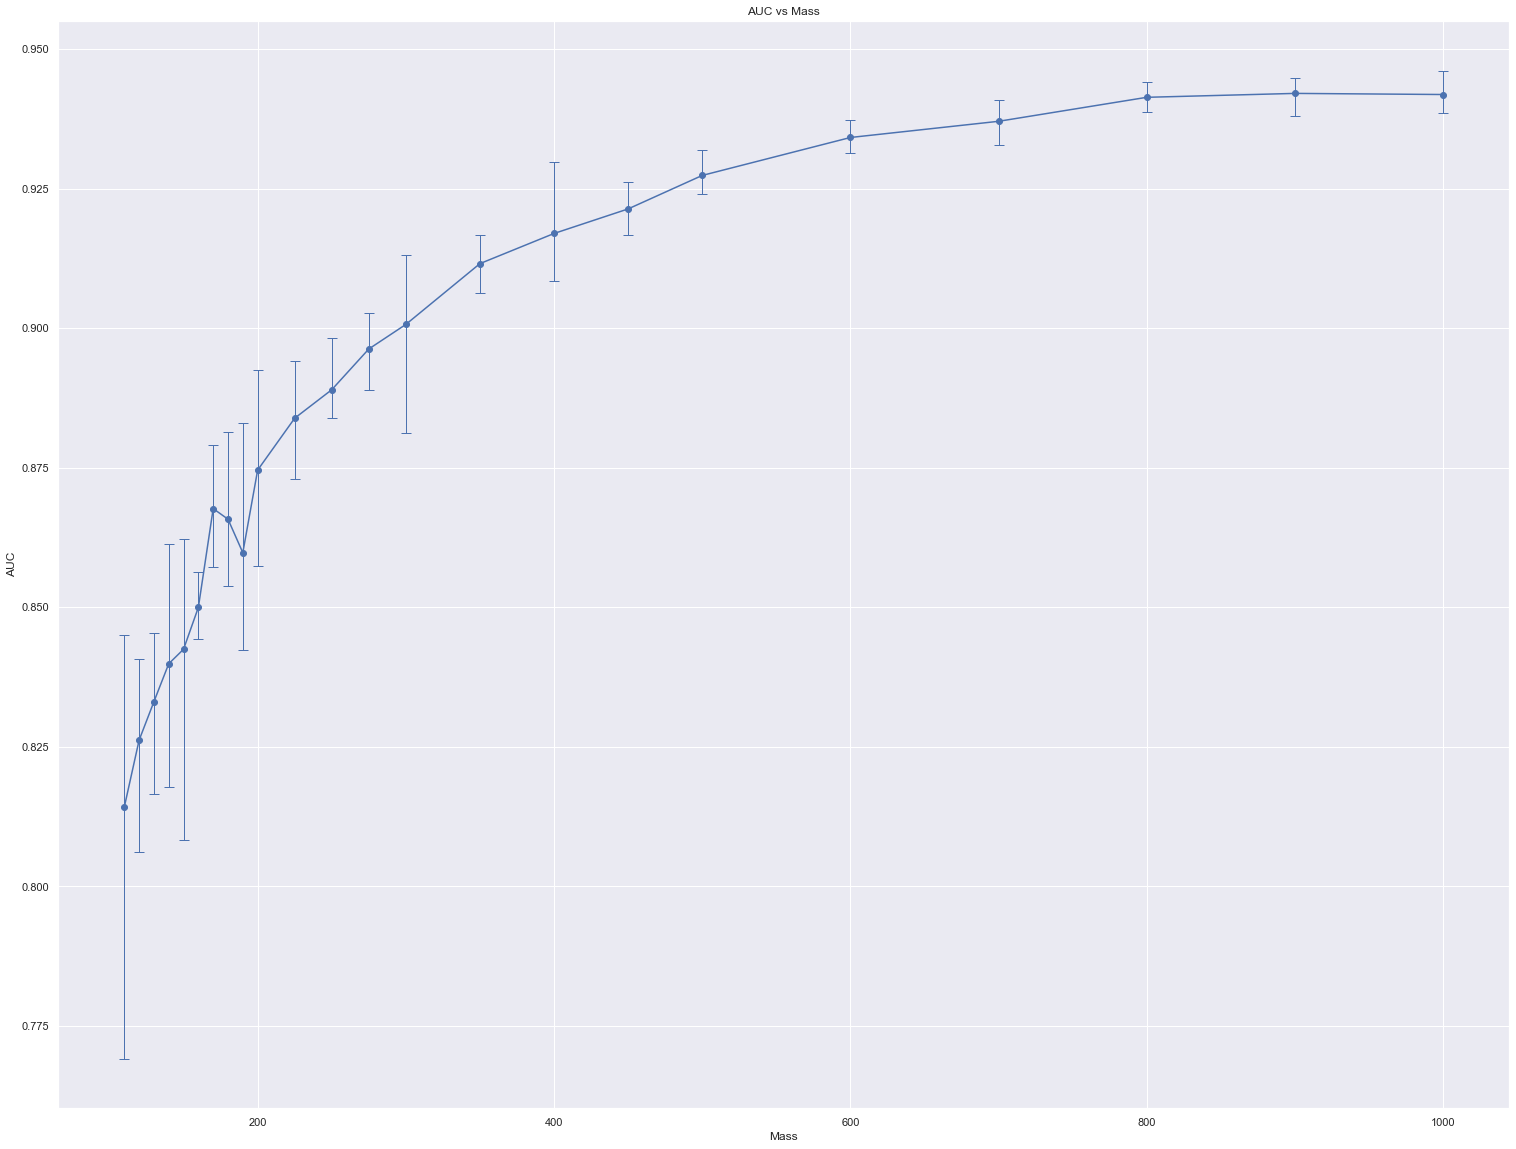

array([0.81417, 0.82621, 0.83311, 0.83991, 0.84247, 0.85001, 0.86768,
       0.86581, 0.85978, 0.87462, 0.88391, 0.88903, 0.89631, 0.90069,
       0.91159, 0.91702, 0.92142, 0.92735, 0.93422, 0.93713, 0.94143,
       0.94207, 0.94187])

In [12]:
auc_with_error(nn, data, silent=True)

Parametric NN:

#### Robust
Clipped outliers.

In [5]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(robust=True)

[signal] loading...
[background] loading...
[Dataset] clipping outliers..
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [6]:
free_mem()
x_train, y_train = data.get()

PNN:

In [7]:
pnn = PNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
          units=[300, 150, 100, 50])

pnn.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                     metrics.Precision(name='precision'), metrics.Recall(name='recal')])

checkpoint = ModelCheckpoint('weights/tom/baseline-pnn-robust/weights-{epoch:02d}-{val_auc:.3f}',
                             save_weights_only=True, monitor='val_auc',
                             mode='max', save_best_only=True)
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          4500        concatenate[0][0]     

In [8]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 95.85, AUC: 99.26

Epoch 1/20
21410/21410 [==============================] - 79s 4ms/step - loss: 0.3136 - binary_accuracy: 0.8402 - auc: 0.9186 - precision: 0.7896 - recal: 0.8632 - lr: 0.0010 - grad-norm: 1.9225 - weight-norm: 37.9460 - reg-losses: 0.0000e+00 - val_loss: 0.3383 - val_binary_accuracy: 0.8432 - val_auc: 0.9256 - val_precision: 0.8150 - val_recal: 0.8271
Epoch 2/20
21410/21410 [==============================] - 76s 4ms/step - loss: 0.2426 - binary_accuracy: 0.8558 - auc: 0.9324 - precision: 0.8077 - recal: 0.8780 - lr: 0.0010 - grad-norm: 2.4675 - weight-norm: 63.9784 - reg-losses: 0.0000e+00 - val_loss: 0.3091 - val_binary_accuracy: 0.8601 - val_auc: 0.9378 - val_precision: 0.8161 - val_recal: 0.8755
Epoch 3/20
21410/21410 [==============================] - 77s 4ms/step - loss: 0.3135 - binary_accuracy: 0.8624 - auc: 0.9381 - precision: 0.8158 - recal: 0.8837 - lr: 0.0010 - grad-norm: 2.7432 - weight-norm: 80.2816 - reg-losses: 0.0000e+00 - val_loss: 0.3029 - val_binary_accuracy: 0.8660 

In [8]:
pnn.load_weights('weights/tom/baseline-pnn-robust/weights-17-0.993')

* With outliers clipping a PNN can gather **+2% in AUC**, thus matching an AffinePNN without its downsides.
* Accuracy is still 2% lower.

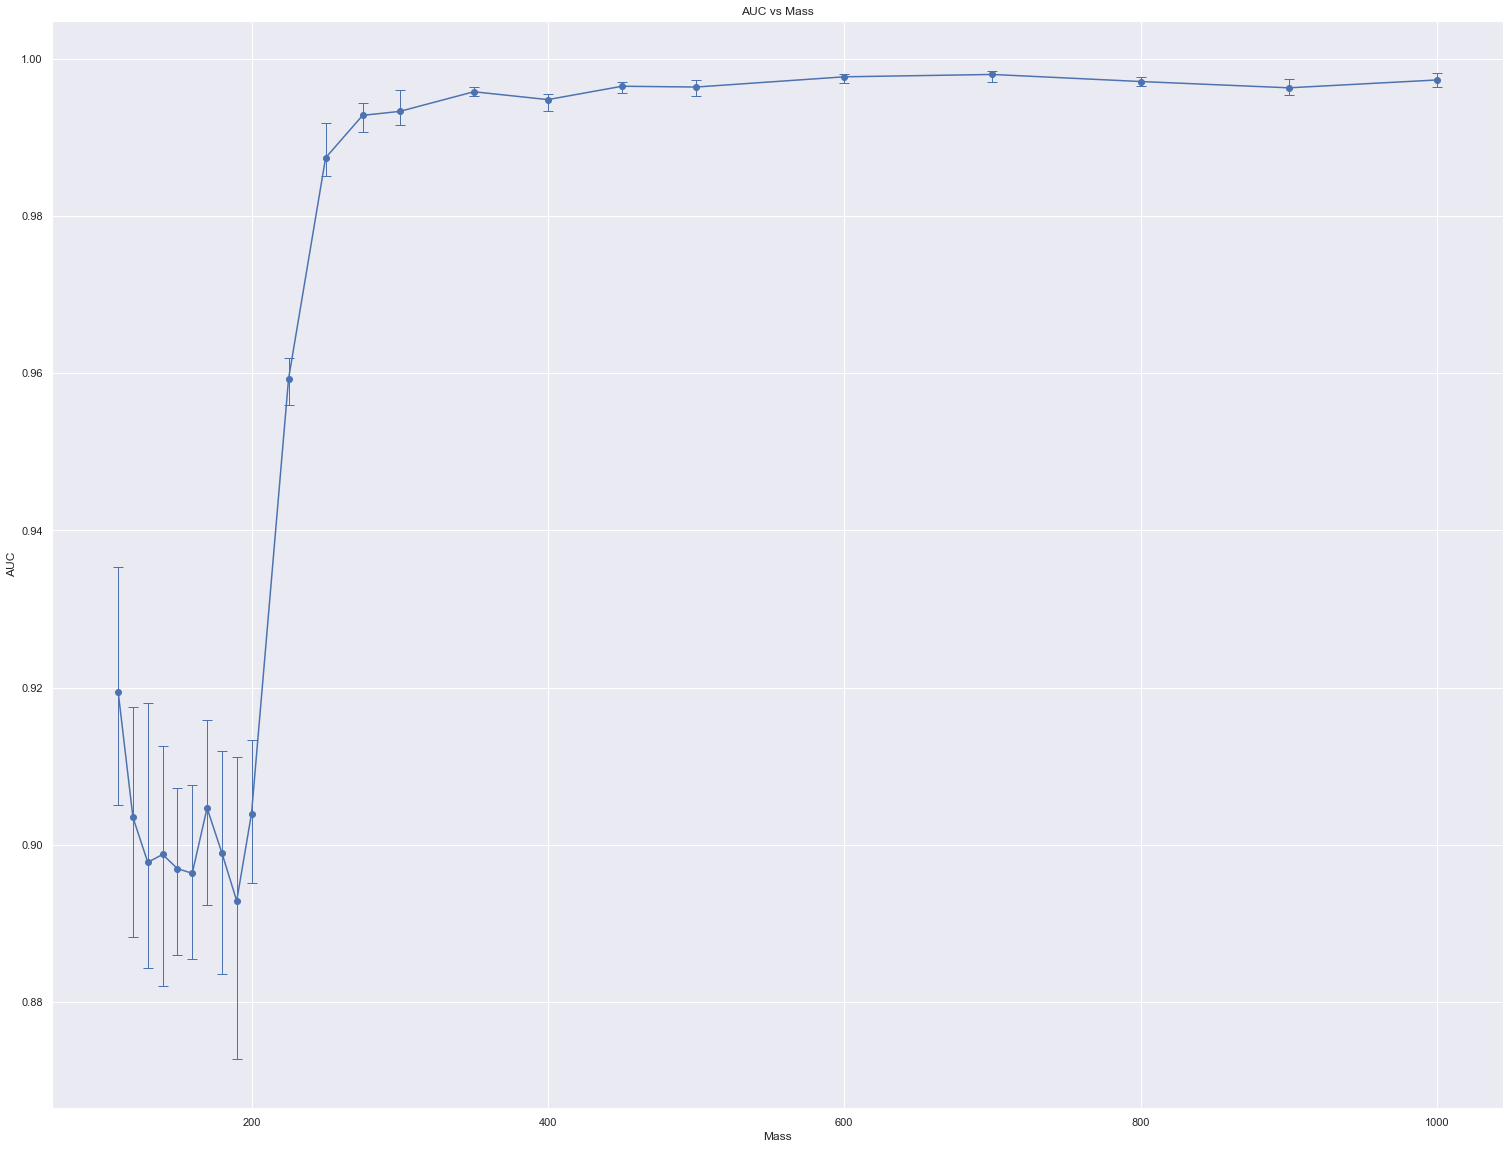

array([0.91952, 0.90347, 0.89782, 0.89876, 0.89698, 0.89635, 0.90466,
       0.89897, 0.89288, 0.90401, 0.95928, 0.98745, 0.99283, 0.99327,
       0.99576, 0.99475, 0.99652, 0.99641, 0.99768, 0.99799, 0.99709,
       0.99627, 0.99728])

In [9]:
auc_with_error(pnn, data, silent=True)

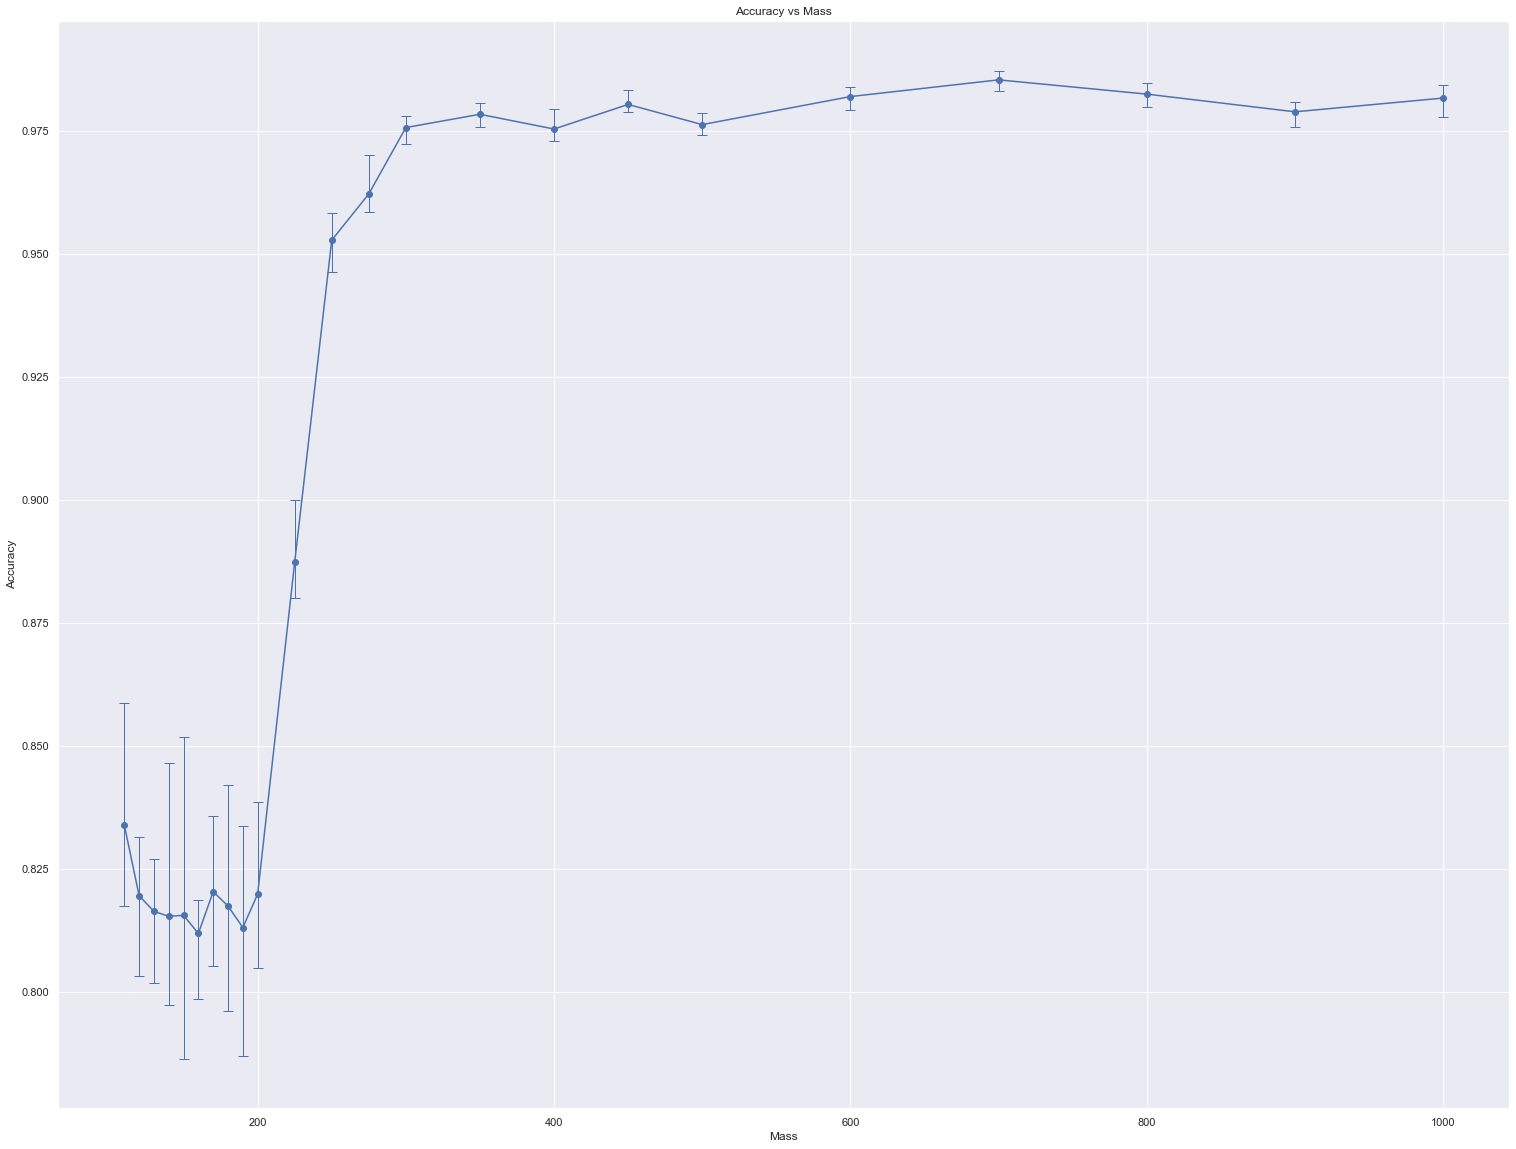

array([0.83392, 0.81947, 0.8163 , 0.81526, 0.81549, 0.81176, 0.82025,
       0.81743, 0.81298, 0.81981, 0.88735, 0.95276, 0.96217, 0.97571,
       0.97837, 0.97544, 0.98036, 0.97628, 0.98196, 0.98539, 0.9825 ,
       0.97892, 0.98174])

In [10]:
metric_with_error(pnn, data, metric='Accuracy', index=1, silent=True)

AffinePNN:

In [11]:
affine = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                   units=[300, 150, 100, 50])

affine.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                        metrics.Precision(name='precision'), metrics.Recall(name='recal')])

checkpoint = ModelCheckpoint('weights/tom/baseline-affine-robust/weights-{epoch:02d}-{val_auc:.3f}',
                             save_weights_only=True, monitor='val_auc',
                             mode='max', save_best_only=True)
affine.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_4[0][0]                    
                                                                 m[0][0]               

In [9]:
h = affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
               epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 97.37, AUC: 99.51

Epoch 1/20
21410/21410 [==============================] - 95s 4ms/step - loss: 0.3248 - binary_accuracy: 0.8352 - auc: 0.9152 - precision: 0.7902 - recal: 0.8464 - cls-loss: 0.3604 - lr: 0.0010 - grad-norm: 1.2132 - weight-norm: 59.1565 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.3374 - val_binary_accuracy: 0.8428 - val_auc: 0.9271 - val_precision: 0.8224 - val_recal: 0.8142
Epoch 2/20
21410/21410 [==============================] - 94s 4ms/step - loss: 0.1237 - binary_accuracy: 0.8855 - auc: 0.9546 - precision: 0.8440 - recal: 0.9044 - cls-loss: 0.2653 - lr: 0.0010 - grad-norm: 8.2854 - weight-norm: 113.9863 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.1761 - val_binary_accuracy: 0.9269 - val_auc: 0.9802 - val_precision: 0.8936 - val_recal: 0.9443
Epoch 3/20
21410/21410 [==============================] - 92s 4ms/step - loss: 0.1375 - binary_accuracy: 0.9318 - auc: 0.9806 - precision: 0.9027 - recal: 0.9453 - cls-loss: 0.1699 - lr: 0.00

In [12]:
affine.load_weights('weights/tom/baseline-affine-robust/weights-20-0.995')

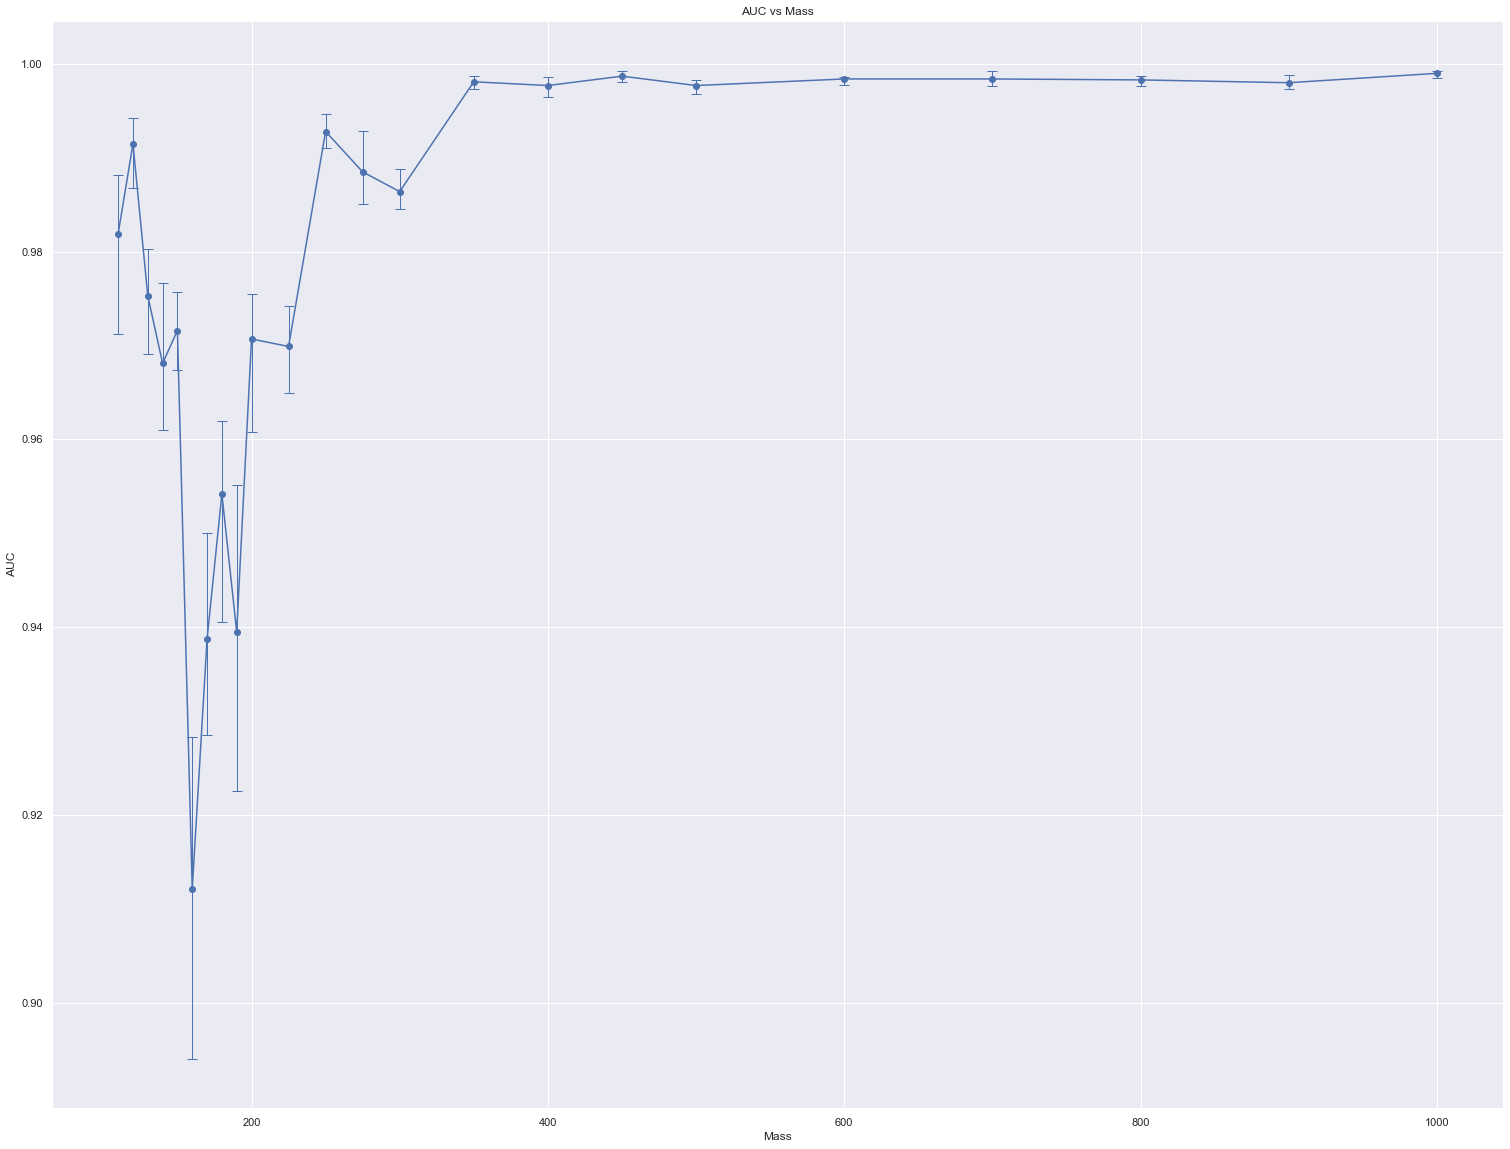

array([0.98188, 0.99154, 0.97528, 0.96811, 0.97155, 0.91214, 0.93866,
       0.95424, 0.93947, 0.97069, 0.96987, 0.99282, 0.98854, 0.98642,
       0.99809, 0.99774, 0.99872, 0.99768, 0.99836, 0.9984 , 0.99829,
       0.99801, 0.99895])

In [13]:
auc_with_error(affine, data, verbose=0, silent=True)

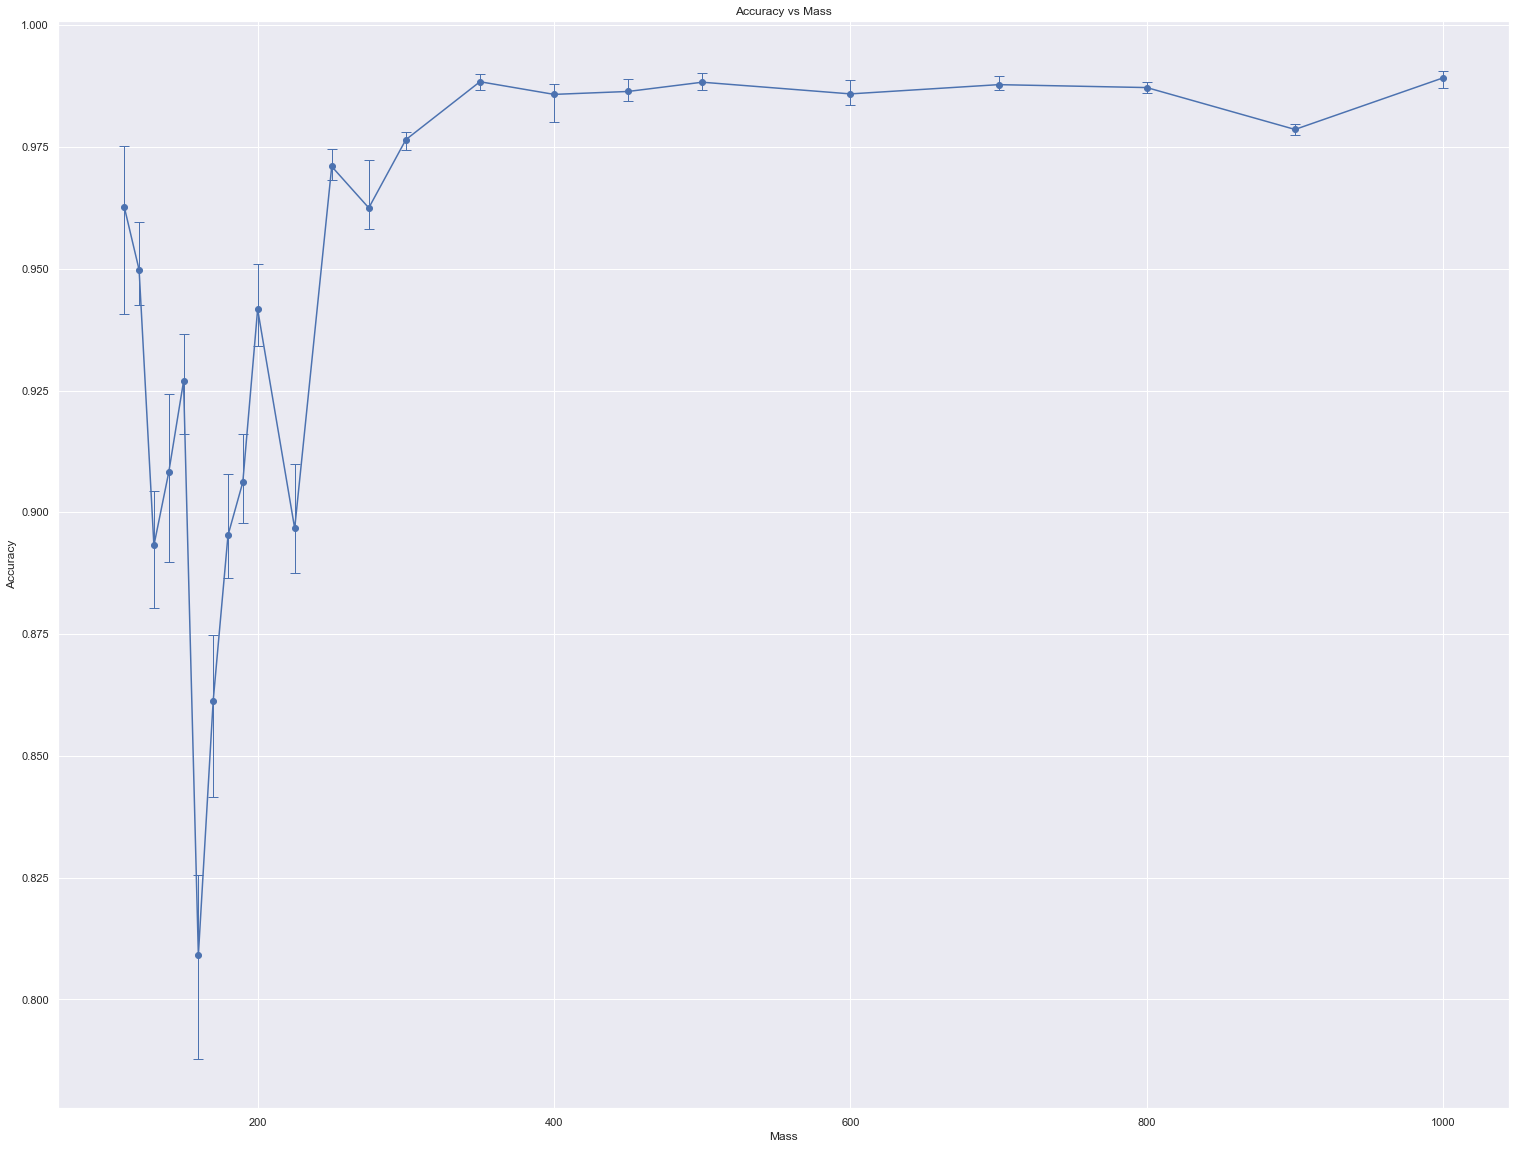

array([0.96268, 0.94975, 0.89325, 0.90817, 0.92686, 0.80906, 0.86134,
       0.89533, 0.90615, 0.94169, 0.89674, 0.97097, 0.96253, 0.97645,
       0.98845, 0.98576, 0.98643, 0.98835, 0.98588, 0.98776, 0.98718,
       0.97856, 0.9892 ])

In [14]:
metric_with_error(affine, data, metric='Accuracy', index=1, verbose=0, silent=True)